In [1]:
import os
import sys

In [2]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [3]:
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')

    # code required by Colab
    %cd /content/drive/MyDrive/PatMatBaselineAlena

    root_dir = '/content/drive/MyDrive/PatMatBaselineAlena'
else:
    current_dir = os.getcwd()
    if current_dir.endswith("notebooks"):
        root_dir = '..'
        %cd ..
    else:
        root_dir = '.'

Mounted at /content/drive
/content/drive/MyDrive/PatMatBaselineAlena


In [4]:
current_dir = os.getcwd()
print(current_dir)

/content/drive/MyDrive/PatMatBaselineAlena


In [5]:
sys.path.append(current_dir)

In [6]:
# install requirements
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [7]:
import json
from datetime import datetime
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np
import mlflow


In [8]:
# # this code uploads the credentials to MLflow given in the .env file
from src.settings import (
    MLFLOW_TRACKING_URI,
    MLFLOW_TRACKING_USERNAME,
    MLFLOW_TRACKING_PASSWORD
)

In [9]:
#ensure path is set correctly and imports are correct
print(MLFLOW_TRACKING_USERNAME)

Alena


In [10]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda')

In [12]:
# Type either "roberta-base" or 'bert-base-uncased' here
model_name = "bert-base-uncased"

In [ ]:
if model_name == "roberta-base":
    # Load the tokenizer
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    # Load the pre-trained ROBERTA model for sequence classification
    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
else:
    from transformers import BertTokenizer, BertForSequenceClassification
    # Load the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Load the pre-trained BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [14]:
def print_memory_usage():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

In [15]:
print("Before loading model:")
print_memory_usage()

Before loading model:
Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


In [16]:
# Move the model to the proper device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
print("After loading model:")
print_memory_usage()

After loading model:
Memory Allocated: 418.74 MB
Memory Reserved: 472.00 MB


In [18]:
print(f"The maximum sequence length for this BERT model is: {tokenizer.model_max_length}")

The maximum sequence length for this BERT model is: 512


In [19]:
def load_jsonl(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl('data/train.jsonl')
validation_data = load_jsonl('data/validation.jsonl')
test_data = load_jsonl('data/test.jsonl')


# Prepare the texts and labels
train_texts = [(item['text'], item['text_b']) for item in train_data]
train_labels = [item['label'] for item in train_data]
validation_texts = [(item['text'], item['text_b']) for item in validation_data]
validation_labels = [item['label'] for item in validation_data]
test_texts = [(item['text'], item['text_b']) for item in test_data]
test_labels = [item['label'] for item in test_data]

In [20]:
len(train_texts), len(train_labels), len(validation_texts), len(validation_labels), len(test_texts), len(test_labels)

(2304, 2304, 577, 577, 769, 769)

In [21]:
# If you don't have a GPU, limit the amount of data
if device.type == 'cpu':
    train_texts = train_texts[:10]
    train_labels = train_labels[:10]
    validation_texts = validation_texts[:10]
    validation_labels = validation_labels[:10]
    test_texts = test_texts[:10]
    test_labels = test_labels[:10]

In [22]:
def explore_text_lengths(texts, index):
    mapping = {
        0: "Train set",
        1: "Validation set",
        2: "Test set"
    }

    print(f"{mapping[index]}")

    # Calculate token lengths using the tokenizer
    token_lengths = [len(tokenizer.encode(item[0], item[1], truncation=False, add_special_tokens=True)) for item in texts]

    sorted_lengths = np.sort(token_lengths)
    percentile_95_length = np.percentile(sorted_lengths, 95)
    print(f"The number of tokens at which 95% of the texts fit is: {percentile_95_length}")

    max_length = 512  # You can adjust this value as needed
    num_texts_below_given_length = np.sum(sorted_lengths <= max_length)
    percentage_texts_below_given_length = (num_texts_below_given_length / len(sorted_lengths)) * 100
    print(f"The percentage of combined texts below {max_length} tokens is: {percentage_texts_below_given_length:.2f}%")

    max_index = [(i, length) for (i, length) in enumerate(token_lengths) if length > max_length]
    print(f"The number of examples where combined text will be truncated (> {max_length} tokens) is: {len(max_index)}")

    # Visualize the distribution of the lengths of the combined texts
    plt.hist(token_lengths, bins=100)
    plt.axvline(percentile_95_length, color='r', linestyle='dashed', linewidth=1)
    plt.title(f'Distribution of Combined Text Lengths, {mapping[index]}')
    plt.xlabel('Length (number of tokens)')
    plt.ylabel('Frequency')
    plt.show()

Train set


Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors


The number of tokens at which 95% of the texts fit is: 394.8499999999999
The percentage of combined texts below 512 tokens is: 98.48%
The number of examples where combined text will be truncated (> 512 tokens) is: 35


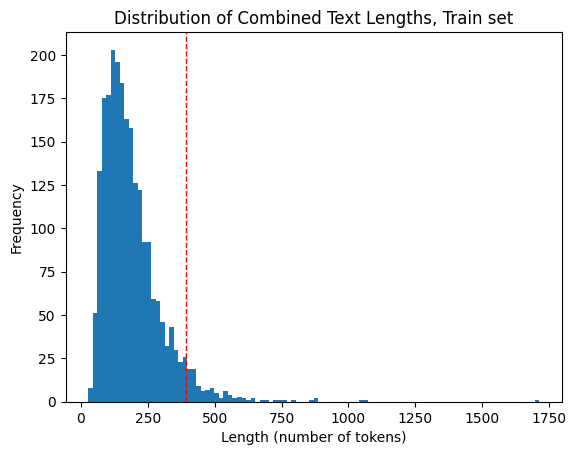

Validation set
The number of tokens at which 95% of the texts fit is: 358.5999999999998
The percentage of combined texts below 512 tokens is: 98.96%
The number of examples where combined text will be truncated (> 512 tokens) is: 6


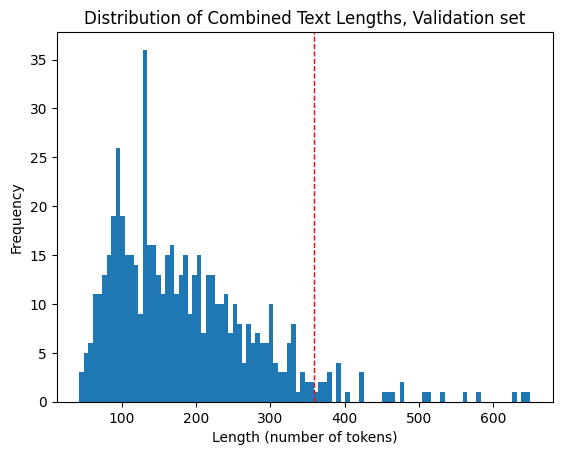

Test set
The number of tokens at which 95% of the texts fit is: 398.1999999999998
The percentage of combined texts below 512 tokens is: 98.96%
The number of examples where combined text will be truncated (> 512 tokens) is: 8


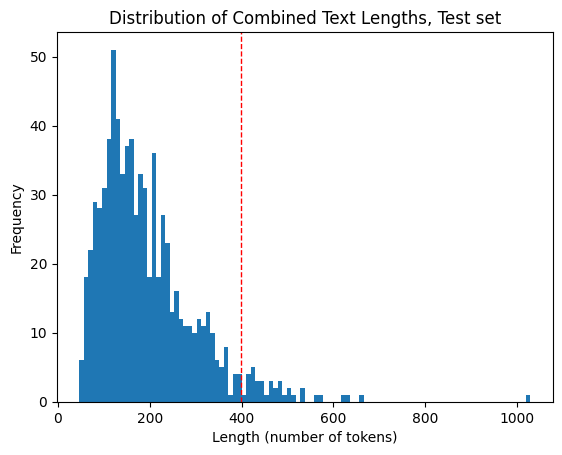

In [23]:
for i, texts in enumerate([train_texts, validation_texts, test_texts]):
    explore_text_lengths(texts, i)

In [24]:
config = {
    'learning_rate': 2e-5,
    'lr_scheduler': "StepLR",
    'gamma': 0.1,
    'step_size': 1,
    'batch_size': 32,
    'num_epochs': 4,
    'max_length': 512,
    'test_size': 0.2,
    'random_state': 42,
    'base_model': model_name
}

In [ ]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])
validation_encodings = tokenizer(validation_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])
test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])

train_input_ids = train_encodings['input_ids']
train_attention_mask = train_encodings['attention_mask']

validation_input_ids = validation_encodings['input_ids']
validation_attention_mask = validation_encodings['attention_mask']

test_input_ids = test_encodings['input_ids']
test_attention_mask = test_encodings['attention_mask']

# Convert labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [ ]:
decoded = tokenizer.decode(train_encodings["input_ids"][0])
print(len(train_encodings["input_ids"][0]))
at_mask = train_encodings["attention_mask"][0]
print(at_mask)

In [ ]:
train_input_ids.shape, train_attention_mask.shape, validation_input_ids.shape, validation_attention_mask.shape, test_input_ids.shape, test_attention_mask.shape

In [ ]:
train_labels.shape, validation_labels.shape, test_labels.shape

In [29]:
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
validation_data = TensorDataset(validation_input_ids, validation_attention_mask, validation_labels)
test_data = TensorDataset(test_input_ids, test_attention_mask, test_labels)

In [30]:
train_data.tensors[0].shape, train_data.tensors[1].shape, train_data.tensors[2].shape

(torch.Size([2304, 512]), torch.Size([2304, 512]), torch.Size([2304]))

In [31]:
validation_data.tensors[0].shape, validation_data.tensors[1].shape, validation_data.tensors[2].shape

(torch.Size([577, 512]), torch.Size([577, 512]), torch.Size([577]))

In [32]:
test_data.tensors[0].shape, test_data.tensors[1].shape, test_data.tensors[2].shape

(torch.Size([769, 512]), torch.Size([769, 512]), torch.Size([769]))

In [33]:
train_dataloader = DataLoader(train_data, batch_size=config["batch_size"])
validation_dataloader = DataLoader(validation_data, batch_size=config["batch_size"])
test_dataloader = DataLoader(test_data, batch_size=config["batch_size"])

In [34]:
for batch in train_dataloader:
    print(batch[0].shape, batch[1].shape, batch[2].shape)
    break

torch.Size([32, 512]) torch.Size([32, 512]) torch.Size([32])


In [35]:
# Define the optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config['step_size'], gamma=config['gamma'])

In [36]:
user = MLFLOW_TRACKING_USERNAME
experiment_name = 'Alena_PatentMatchBaseline'


def timestamp():
    """This function creates current timestamp"""
    return datetime.now().strftime("%Y_%m_%d_%H%M_%S")

In [37]:
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None or experiment.lifecycle_stage == 'deleted':
    mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)

In [38]:
model_save_path = f'models/{timestamp()}'

if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

In [39]:
def calculate_and_log_train_metrics_and_hp(train_loss, epoch):
    # Log the average training loss for the epoch
    avg_train_loss = train_loss / len(train_dataloader)
    mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
    print(f"Average training loss for epoch {epoch + 1}: {avg_train_loss}")

    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    mlflow.log_metric("learning_rate", current_lr, step=epoch)
    print(f"Current learning rate for epoch {epoch + 1}: {current_lr}")

In [40]:
def calculate_and_log_metrics(true_labels, predictions, epoch=None, test=False):
    step = "test" if test else "val"

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, zero_division='warn')
    recall = recall_score(true_labels, predictions, zero_division="warn")
    f1 = f1_score(true_labels, predictions, zero_division="warn")
    mcc = matthews_corrcoef(true_labels, predictions)

    # Log metrics
    mlflow.log_metric(f"{step}_accuracy", accuracy, step=epoch)
    mlflow.log_metric(f"{step}_precision", precision, step=epoch)
    mlflow.log_metric(f"{step}_recall", recall, step=epoch)
    mlflow.log_metric(f"{step}_f1", f1, step=epoch)
    mlflow.log_metric(f"{step}_mcc", mcc, step=epoch)

    print(f"{step} Accuracy: {accuracy}")
    print(f"{step} Precision: {precision}")
    print(f"{step} Recall: {recall}")
    print(f"{step} F1 Score: {f1}")
    print(f"{step} MCC: {mcc}")

    return mcc

In [41]:
def calculate_and_log_cm(true_labels, predictions, epoch=None, test=False):
    step = "test" if test else "val"

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predictions, normalize='true')
    cm_filename = f"artifacts/{step}_{timestamp()}_confusion_matrix_epoch_{epoch}.csv"
    np.savetxt(cm_filename, cm, delimiter=",")
    mlflow.log_artifact(cm_filename)
    print(cm)

In [42]:
with mlflow.start_run(experiment_id=experiment.experiment_id) as run:
    run_id = run.info.run_id
    for param_name, param_value in config.items():
        mlflow.log_param(param_name, param_value)

    best_mcc = -1

    for epoch in range(config['num_epochs']):  # Number of training epochs
        print(f'############### Started {epoch + 1} epoch ###############')

        # Set run name
        mlflow.set_tag(key='mlflow.runName', value=f'{timestamp()}_{user}')

        print(f'Started training on {epoch + 1} epoch')
        model.train()
        train_loss = 0.0
        for batch in train_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            train_loss += loss.item()

        calculate_and_log_train_metrics_and_hp(train_loss, epoch)
        print(f'Finished training on {epoch + 1} epoch')

        # Validation loop
        print(f'Started validation on {epoch + 1} epoch')
        model.eval()
        val_loss = 0.0
        val_predictions, val_true_labels = [], []
        for batch in validation_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

            logits = outputs.logits
            loss = outputs.loss
            val_loss += loss.item()

            val_predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())
            val_true_labels.extend(b_labels.cpu().tolist())

        # Log the average validation loss for the epoch
        avg_val_loss = val_loss / len(validation_dataloader)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
        print(f"Average validation loss for epoch {epoch + 1}: {avg_val_loss}")

        mcc = calculate_and_log_metrics(val_true_labels, val_predictions, epoch)
        print(f"Current best Matthew correlation coefficient: {best_mcc}")

        # Save the best model based on the Matthew correlation coefficient
        if mcc > best_mcc:
            best_mcc = mcc
            print(f"New best model with MCC: {best_mcc}")
            best_model_path = os.path.join(model_save_path, "best")
            if not os.path.exists(best_model_path):
                os.makedirs(best_model_path)
            model_to_save = model.module if hasattr(model, 'module') else model
            model_to_save.save_pretrained(best_model_path)
            tokenizer.save_pretrained(best_model_path)

        calculate_and_log_cm(val_true_labels, val_predictions, epoch)
        print(f'Finished validation on {epoch + 1} epoch')
        print(f'############### Finished {epoch + 1} epoch ###############\n')

        # Update the learning rate scheduler
        scheduler.step()

    last_model_path = os.path.join(model_save_path, "last")
    if not os.path.exists(last_model_path):
        os.makedirs(last_model_path)
    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.save_pretrained(last_model_path)
    tokenizer.save_pretrained(last_model_path)

mlflow.end_run()

############### Started 1 epoch ###############
Started training on 1 epoch
Average training loss for epoch 1: 0.687690874768628
Current learning rate for epoch 1: 2e-05
Finished training on 1 epoch
Started validation on 1 epoch
Average validation loss for epoch 1: 0.6670534077443575
val Accuracy: 0.5892547660311959
val Precision: 0.5949820788530465
val Recall: 0.967930029154519
val F1 Score: 0.7369589345172032
val MCC: 0.005827738186849235
Current best Matthew correlation coefficient: 0.005827738186849235
[[0.03418803 0.96581197]
 [0.03206997 0.96793003]]
Finished validation on 1 epoch
############### Finished 1 epoch ###############

############### Started 2 epoch ###############
Started training on 2 epoch
Average training loss for epoch 2: 0.6614761542942789
Current learning rate for epoch 2: 2.0000000000000003e-06
Finished training on 2 epoch
Started validation on 2 epoch
Average validation loss for epoch 2: 0.67366539804559
val Accuracy: 0.608318890814558
val Precision: 0.626349

In [44]:
# Choose the best or the last model for evaluation
if os.path.exists(os.path.join(model_save_path, "best")) and os.path.isdir(os.path.join(model_save_path, "best")):
    model_path_for_evaluation = best_model_path
    print("Evaluation with the best saved model")
else:
    model_path_for_evaluation = last_model_path
    print("Evaluation with the last saved model")

# Download the saved model
if model_name == "roberta-base":
    tokenizer = AutoTokenizer.from_pretrained(model_path_for_evaluation)
    model = AutoModelForSequenceClassification.from_pretrained(model_path_for_evaluation)
else:
    tokenizer = BertTokenizer.from_pretrained(model_path_for_evaluation)
    model = BertForSequenceClassification.from_pretrained(model_path_for_evaluation)

model.to(device)

with mlflow.start_run(run_id=run_id):
    # # Evaluate on the test set
    print(f'Started evaluation on test set')
    model.eval()
    test_loss = 0.0
    test_predictions, test_true_labels = [], []
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = batch

        # Move the batch to the proper device
        b_input_ids = b_input_ids.to(device)
        b_attention_mask = b_attention_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

        logits = outputs.logits
        loss = outputs.loss
        test_loss += loss.item()

        test_predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())
        test_true_labels.extend(b_labels.cpu().tolist())

    # Log the average test loss
    avg_test_loss = test_loss / len(test_dataloader)
    mlflow.log_metric("test_loss", avg_test_loss, config['num_epochs'])
    print(f"Average test loss: {avg_test_loss}")

    calculate_and_log_metrics(test_true_labels, test_predictions, config['num_epochs'], test=True)
    calculate_and_log_cm(test_true_labels, test_predictions, config['num_epochs'], test=True)

    print(f'Finished evaluation on test set')

mlflow.end_run()

Evaluation with the best saved model
Started evaluation on test set
Average test loss: 0.6886850786209107
test Accuracy: 0.5513654096228868
test Precision: 0.5262237762237763
test Recall: 0.8026666666666666
test F1 Score: 0.6356916578669483
test MCC: 0.13151078720912032
[[0.31218274 0.68781726]
 [0.19733333 0.80266667]]
Finished evaluation on test set
